# Insight on Liquor beverage consumption in IOWA State

### Scenario

The Iowa State legislature is considering changes in the liquor tax rates and wants a report of current liquor sales by county and projections for the rest of the year.

Since the national US prohibition of 1933, IOWA is Alcoholic beverage control states, which means in the case of that state that _All spirits are sold to privately owned retailers by the Iowa Alcoholic Beverages Division. Beer and wine can be sold by private license-holders._
In other words, the IOWA states act as a unique wholesaler, buying alcoholic beverage and then sell to stores.

This study aims at returning the best model to predict the Sales by store for Liquor beverage in the IOWA states. Thereafter use this study to look at the benefice of increasing (respectively decreasing) this tax for Iowa states legislature taking into account all different voices such as Consumer group representative,  Public health representative, lobbyist from beverage alcohol industry, liquor store manager unions. 

Thus, I'll proceed as following:
1. Explorate [Iowa.gov](Iowa.gov) sales history for that states, its seasonability and tendency , also trying to catch any outliers (i.e due to special promotional events for example) that might affect future prediction;
1.  Highlights correlations/causations
1. Define the demand forecast unit that will fit the best the future model of prediction.(i.e Sales*Store*month vs Sales*store*liquor_cat*month);
1. Test different linear model to get the more suitable forecast using regression and k-fold cross-validation;
1. After selecting best model,  predict future sales in function of liquor tax rates.

In [2]:
import pandas as pd

#Load the data into a DataFrame
df=pd.read_csv("Iowa_Liquor_Sales_reduced.csv")

/Users/dorian/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## Transform the data types of: Dates, States Bottle Cost, State Bootle Retail, Sales

df["Date"]=pd.to_datetime(df["Date"],format="%m/%d/%Y")
df["State Bottle Cost"]=df["State Bottle Cost"].str.lstrip('$').astype('float')
df["State Bottle Retail"]=df["State Bottle Retail"].str.lstrip('$').astype('float')
df["Sale (Dollars)"]=df["Sale (Dollars)"].str.lstrip('$').astype('float')

In [4]:
# Let's rename some columns for a better comprehension
# State bottle Cost: The amount that Alcoholic Beverages Division (States of IOWA) paid for each bottle of liquor ordered.
# State Bottle Retail: The amount the store paid for each bottle of liquor ordered to the Alcoholic Beverages Division

dic_ren_col={'State Bottle Cost':'Bottle_Cost_taxfree_(USD)',\
             'State Bottle Retail':'Bottle_Cost_inc_tax_(USD)',\
            'Sale (Dollars)': 'Sales_inc_tax(USD)'}
df=df.rename(columns=dic_ren_col)
df.dtypes

Date                         datetime64[ns]
Store Number                          int64
City                                 object
Zip Code                             object
County Number                       float64
County                               object
Category                            float64
Category Name                        object
Vendor Number                         int64
Item Number                           int64
Item Description                     object
Bottle Volume (ml)                    int64
Bottle_Cost_taxfree_(USD)           float64
Bottle_Cost_inc_tax_(USD)           float64
Bottles Sold                          int64
Sales_inc_tax(USD)                  float64
Volume Sold (Liters)                float64
Volume Sold (Gallons)               float64
dtype: object

In [5]:
print "Years studied:", df["Date"].dt.year.unique()
df.shape

Years studied: [2016 2015]


(2709552, 18)

In [6]:
# creation of columns: week number, month and year.

df["year"]=df["Date"].dt.year
df["weeknum"]=df["Date"].dt.week
df["month"]=df["Date"].dt.month

In [33]:
df.columns

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'Bottle_Cost_taxfree_(USD)', u'Bottle_Cost_inc_tax_(USD)',
       u'Bottles Sold', u'Sales_inc_tax(USD)', u'Volume Sold (Liters)',
       u'Volume Sold (Gallons)', u'year', u'weeknum', u'month', u'tax'],
      dtype='object')

In [38]:
pd.set_option("display.max_columns",200)

chosen=[u'Date', u'Store Number',\
       u'County', u'Category Name',\
       u'Item Number',\
       u'Bottle_Cost_taxfree_(USD)', u'Bottle_Cost_inc_tax_(USD)',\
       u'Bottles Sold', u'Sales_inc_tax(USD)', u'Volume Sold (Liters)']
df.loc[:,chosen].head()

,Date,Store Number,County,Category Name,Item Number,Bottle_Cost_taxfree_(USD),Bottle_Cost_inc_tax_(USD),Bottles Sold,Sales_inc_tax(USD),Volume Sold (Liters)
0,2016-03-31,5029,Scott,TEQUILA,87152,9.99,14.99,12,179.88,4.50
1,2016-03-31,5029,Scott,TEQUILA,89197,12.50,18.75,2,37.50,2.00
2,2016-03-31,4959,Black Hawk,AMERICAN COCKTAILS,63959,5.97,8.96,6,53.76,10.50
3,2016-03-31,2190,Polk,VODKA FLAVORED,40597,2.24,3.36,48,161.28,9.60
5,2016-03-31,4988,Black Hawk,STRAIGHT BOURBON WHISKIES,17090,23.00,34.50,1,34.50,0.75


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

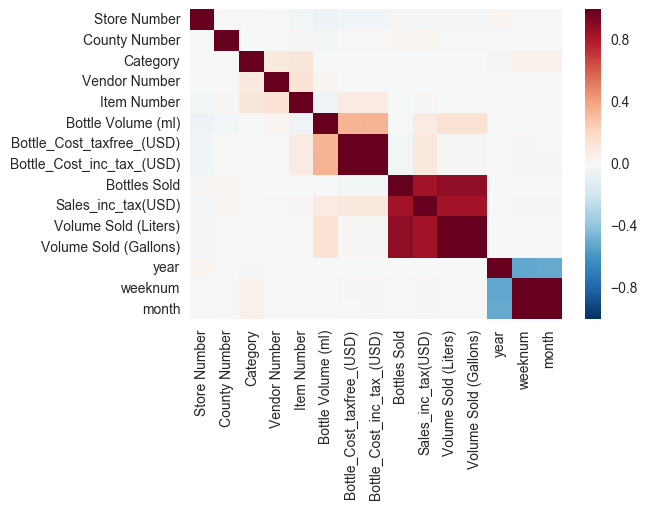

In [9]:
sns.heatmap(df.corr())
sns.plt.show()

No unsurprised correlation is discovered from that chart.

In [10]:
#create a tax column
df["tax"]=(df["Bottle_Cost_inc_tax_(USD)"]-df["Bottle_Cost_taxfree_(USD)"])/df["Bottle_Cost_taxfree_(USD)"]
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),Bottle_Cost_taxfree_(USD),Bottle_Cost_inc_tax_(USD),Bottles Sold,Sales_inc_tax(USD),Volume Sold (Liters),Volume Sold (Gallons),year,weeknum,month,tax
0,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,9.99,14.99,12,179.88,4.5,1.19,2016,13,3,0.500501
1,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,12.50,18.75,2,37.50,2.0,0.53,2016,13,3,0.500000
2,2016-03-31,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,5.97,8.96,6,53.76,10.5,2.77,2016,13,3,0.500838
3,2016-03-31,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,2.24,3.36,48,161.28,9.6,2.54,2016,13,3,0.500000
4,2016-03-31,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,12.50,18.75,6,112.50,4.5,1.19,2016,13,3,0.500000


In [11]:
a=len(df.dropna())
b=len(df)

print "we have got %d rows with missing value among %d rows, which represent %f %%.\nWe can delete those rows"\
%(b-a,b,round((b-a)*100/b,2))

we have got 16950 rows with missing value among 2709552 rows, which represent 0.000000 %.
We can delete those rows


In [12]:
df=df.dropna()

In [13]:
df_2015=df.loc[df["Date"].dt.year==2015,:]
df_2015.reset_index(drop=True,inplace=True)

In [14]:
area=df_2015.groupby(["County"])["Vendor Number"].size()
print "There are %d County with on average %d liquor store"%(len(area),np.mean(area.values))
print "10 County with higher number of liquor store"
area.sort_values(ascending=False,inplace=True)
print area["Polk":"Cerro Gordo"]

There are 99 County with on average 22039 liquor store
10 County with higher number of liquor store
County
Polk             394281
Linn             187767
Scott            134646
Black Hawk       120912
Johnson          108745
Pottawattamie     73867
Story             72709
Woodbury          69132
Dubuque           62181
Cerro Gordo       52197
dtype: int64


In [39]:
pivot_table1=pd.pivot_table(df_2015,index=["Category Name"],values=["Item Number","Volume Sold (Liters)","tax"],\
                            aggfunc={"Item Number":np.size,"Volume Sold (Liters)":np.sum,"tax":[np.mean,np.std]})
col_pivot=list(pivot_table1.columns)
pivot_table1.sort(columns=col_pivot[-1],ascending=False,inplace=True,axis=0)
print "10 best seller"
pivot_table1[:10]

10 best seller


/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


Item Number       tax            \
                                        size      mean       std   
Category Name                                                      
VODKA 80 PROOF                        284276  0.502301  0.010785   
CANADIAN WHISKIES                     216124  0.504488  0.015193   
SPICED RUM                            116940  0.500670  0.006777   
WHISKEY LIQUEUR                        86895  0.500855  0.004954   
STRAIGHT BOURBON WHISKIES             123962  0.503531  0.012067   
BLENDED WHISKIES                       93120  0.500499  0.003247   
IMPORTED VODKA                         88409  0.500420  0.003883   
PUERTO RICO & VIRGIN ISLANDS RUM       81131  0.501953  0.010075   
TEQUILA                                98447  0.501498  0.010612   
AMERICAN COCKTAILS                     55709  0.509356  0.021962   

                                 Volume Sold (Liters)  
                                                  sum  
Category Name                                          
VODKA 80 PROOF                           3.995266e+06  
CANADIAN WHISKIES                        2.656094e+06  
SPICED RUM                               1.437968e+06  
WHISKEY LIQUEUR                          8.616581e+05  
STRAIGHT BOURBON WHISKIES                8.431430e+05  
BLENDED WHISKIES                         8.299601e+05  
IMPORTED VODKA                           8.148190e+05  
PUERTO RICO & VIRGIN ISLANDS RUM         7.895692e+05  
TEQUILA                                  7.484591e+05  
AMERICAN COCKTAILS                       6.371520e+05

It seems that tax varies a bit, this would be related to the fact that the IOWA state buy and sell as a wholesaler and not just adding a VAT.  
Let's check the dregree of variation for the liquor tax in 2015.

In [16]:
print "Liquor tax mean : %f %%"%round(np.mean(df_2015["tax"])*100,2)
print "Liquor tax std: %f %%"%round(np.std(df_2015["tax"])*100,2)

Liquor tax mean : 50.230000 %
Liquor tax std: 1.260000 %


The variance is almost nil, we can consider that the tax is about 50% of the buying value for a store.

In [17]:
#it seems there are different categories name for whiskies ,vodka and gins.
#To have a better look of the distribution per liquor and for future predictions, let's create a general category

main_liquor=["WHISKIES","VODKA","RUM","TEQUILA","GINS","SCHNAPPS","AMARETTO","LIQUEURS","BRANDIES"]

def cat_liquor(row):
    name=row.split(' ')
    for item in name:
        result=row
        if item in main_liquor:
            result=item
            break
        elif item in ["SCOTCH","WHISKY"]:
            result="WHISKIES"
            break
    return result

df_2015["Cat_general"]=df_2015["Category Name"].apply(cat_liquor)

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
pivot_table1=pd.pivot_table(df_2015,index=["Cat_general"],values=["Item Number","Volume Sold (Liters)","Sales_inc_tax(USD)"],\
                            aggfunc={"Item Number":np.size,\
                                     "Volume Sold (Liters)":[np.sum,lambda x: round(100*np.sum(x)/sum(df_2015["Volume Sold (Liters)"]),1)],\
                                    "Sales_inc_tax(USD)":[np.sum,lambda x: round(100*np.sum(x)/sum(df_2015["Sales_inc_tax(USD)"]),1)]})
col_pivot=list(pivot_table1.columns)
pivot_table1.rename(columns={'size': 'Num of brands',"<lambda>":'%'}, inplace=True)
pivot_table1.sort(columns=col_pivot[-1],ascending=False,inplace=True,axis=0)
pivot_table1

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Sales_inc_tax(USD)                 Item Number  \
                                                %           sum Num of brands   
Cat_general                                                                     
VODKA                                        24.0  6.812212e+07        565645   
WHISKIES                                     31.3  8.887399e+07        588478   
RUM                                          13.0  3.695967e+07        263716   
WHISKEY LIQUEUR                               5.1  1.453575e+07         86895   
LIQUEURS                                      6.5  1.832719e+07        147804   
SCHNAPPS                                      3.6  1.010213e+07        114875   
TEQUILA                                       5.6  1.581558e+07         98447   
AMERICAN COCKTAILS                            1.5  4.394948e+06         55709   
BRANDIES                                      4.2  1.178275e+07        119720   
GINS                                          2.7  7.629755e+06         81621   
TRIPLE SEC                                    0.2  7.039670e+05          9561   
DISTILLED SPIRITS SPECIALTY                   0.6  1.663084e+06         11879   
DECANTERS & SPECIALTY PACKAGES                1.0  2.958077e+06         10577   
AMARETTO                                      0.3  9.708137e+05         13686   
AMERICAN ALCOHOL                              0.2  6.123314e+05          4847   
GREEN CREME DE MENTHE                         0.0  7.228023e+04          1866   
WHITE CREME DE CACAO                          0.0  5.617732e+04          1447   
DARK CREME DE CACAO                           0.0  5.163673e+04          1373   
BOTTLED IN BOND BOURBON                       0.1  2.055630e+05          1806   
ROCK & RYE                                    0.0  3.398115e+04           716   
WHITE CREME DE MENTHE                         0.0  1.885501e+04           558   
CREME DE ALMOND                               0.0  1.154037e+04           333   
ANISETTE                                      0.0  9.757930e+03           337   
HIGH PROOF BEER - AMERICAN                    0.0  8.565600e+02             6   

                               Volume Sold (Liters)              
                                                  %         sum  
Cat_general                                                      
VODKA                                          30.4  5966398.32  
WHISKIES                                       27.4  5374769.41  
RUM                                            13.5  2648323.93  
WHISKEY LIQUEUR                                 4.4   861658.07  
LIQUEURS                                        4.1   805401.15  
SCHNAPPS                                        4.0   779605.22  
TEQUILA                                         3.8   748459.07  
AMERICAN COCKTAILS                              3.3   637152.02  
BRANDIES                                        3.0   597213.62  
GINS                                            2.9   565950.69  
TRIPLE SEC                                      0.9   172256.00  
DISTILLED SPIRITS SPECIALTY                     0.8   154941.72  
DECANTERS & SPECIALTY PACKAGES                  0.6   123440.65  
AMARETTO                                        0.5    97008.92  
AMERICAN ALCOHOL                                0.2    34438.35  
GREEN CREME DE MENTHE                           0.0     7700.25  
WHITE CREME DE CACAO                            0.0     5985.00  
DARK CREME DE CACAO                             0.0     5453.25  
BOTTLED IN BOND BOURBON                         0.0     5427.25  
ROCK & RYE                                      0.0     2211.00  
WHITE CREME DE MENTHE                           0.0     1983.75  
CREME DE ALMOND                                 0.0     1268.25  
ANISETTE                                        0.0     1020.75  
HIGH PROOF BEER - AMERICAN                      0.0        4.50

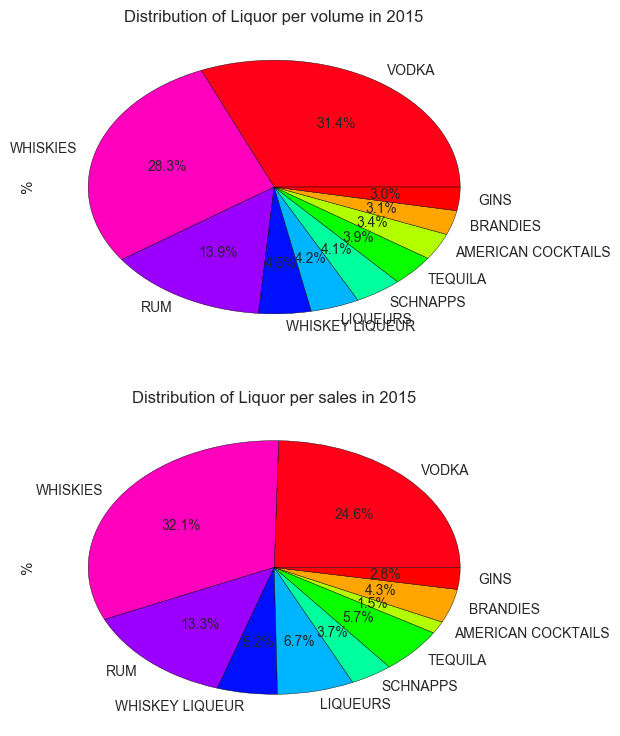

In [19]:
fig=plt.figure(figsize=(8,8))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

pivot_table1[:10][col_pivot[-1][0]].loc[:,"%"].plot.pie(\
                autopct='%1.1f%%', colormap='hsv_r', fontsize=10, figsize=(6, 9),\
                                       title='Distribution of Liquor per volume in 2015',ax=ax1)
pivot_table1[:10][col_pivot[0][0]].loc[:,"%"].plot.pie(\
                autopct='%1.1f%%', colormap='hsv_r', fontsize=10, figsize=(6, 9),\
                                       title='Distribution of Liquor per sales in 2015',ax=ax2)



plt.show()

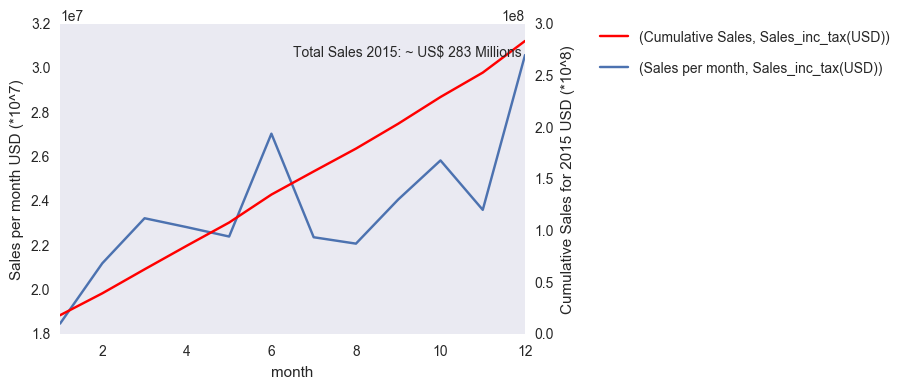

In [20]:
#Let's now look at the sales per months in 2015
pivot_table2=pd.pivot_table(df_2015,index=["month"],values=["Sales_inc_tax(USD)"],\
                            aggfunc= [np.sum])
pivot_table2.rename(columns={'sum':'Sales per month',"<lambda>":'%'}, inplace=True)
pivot_table3=pivot_table2.cumsum()
pivot_table3.rename(columns={'Sales per month':'Cumulative Sales',"<lambda>":'%'}, inplace=True)


fig=plt.figure()
ax=fig.add_subplot(111)
ax2=ax.twinx()
pivot_table2.plot(ax=ax,grid=False,legend=False)

pivot_table3.plot(ax=ax2,c="r",grid=False)

ax.set_ylabel("Sales per month USD (*10^7)")
ax2.set_ylabel("Cumulative Sales for 2015 USD (*10^8)")
plt.annotate("Total Sales 2015: ~ US$ %d Millions"%(np.sum(df_2015["Sales_inc_tax(USD)"])/1000000),xy=(0.5, 0.9), xycoords='axes fraction')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.legend(bbox_to_anchor=(1.15, 0.9), loc=2, borderaxespad=0.)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
ax2.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)

plt.show()

Total sales for liquor in 2015 is about almost US$ 0.3 billions.  
We can notice a certain seasonability where June, October and December are months with higher sales.  
This is certainly due to National day in July, Thanksgiving in November and Christmas/New Year’s eve. Liquor stores seem to order a month in advance to prepare those events. It is also interesting to notice how people slow down in alcohol consumption at the begin of the year. Perhaps as a new year resolution!!  
To confirm those tendency, a look at correlation for several year between month and volume consumption would be relevant but won’t be treated here.  
However other important indicators needs to be checked for our prediction, such as how many weeks per month a store will supply its shelves.  

**This graph also makes us aware of the danger of predicting sales for a whole year taking into account only some months**, for a better result, a regression model has to be performed and validated for a whole year and then apply for a new year.

In [21]:
# let's count how many weeks per month orders are placed per store and also with how many litters are ordered per month per store.
pivot_table4=pd.pivot_table(df_2015,index=["month","Store Number"],values=["weeknum","Volume Sold (Liters)","Sales_inc_tax(USD)"],\
                            aggfunc= {"weeknum":lambda x: len(x.unique()),"Volume Sold (Liters)":np.sum,"Sales_inc_tax(USD)":np.sum})

pivot_table4[:10]

Sales_inc_tax(USD)  Volume Sold (Liters)  weeknum
month Store Number                                                   
1     2106                   109795.48               7116.85        4
      2113                     7685.86                566.74        3
      2130                    71307.51               4338.05        4
      2152                     5746.27                484.86        4
      2178                    17970.36               1454.70        4
      2190                    81494.58               4418.33        4
      2191                    73707.72               5159.63        3
      2200                    13045.11                994.42        3
      2205                    20618.55               1323.51        4
      2228                    14779.55               1276.91        4

In [22]:
# creation of a dataframe with the value of pivot table4
vol_Week_order=pd.DataFrame(data=pivot_table4.values,columns=["Sales_inc_tax(USD)","Volume Sold (Liters)","Number of order"])

# creation of a dataframe with the index of table4
list_of_tuples_month_store = pivot_table4.index.tolist()
list_of_lists = [list(elem) for elem in list_of_tuples_month_store]
list_of_lists[:10]
month_store=pd.DataFrame(data=list_of_lists,columns=["Month","Store Number"])

# concatenation

df_2015_store_order_consumption= pd.concat([month_store,vol_Week_order],axis=1)
df_2015_store_order_consumption.head()

,Month,Store Number,Sales_inc_tax(USD),Volume Sold (Liters),Number of order
0,1,2106,109795.48,7116.85,4.0
1,1,2113,7685.86,566.74,3.0
2,1,2130,71307.51,4338.05,4.0
3,1,2152,5746.27,484.86,4.0
4,1,2178,17970.36,1454.70,4.0


In [23]:
len(df_2015_store_order_consumption)

14718

/Users/dorian/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


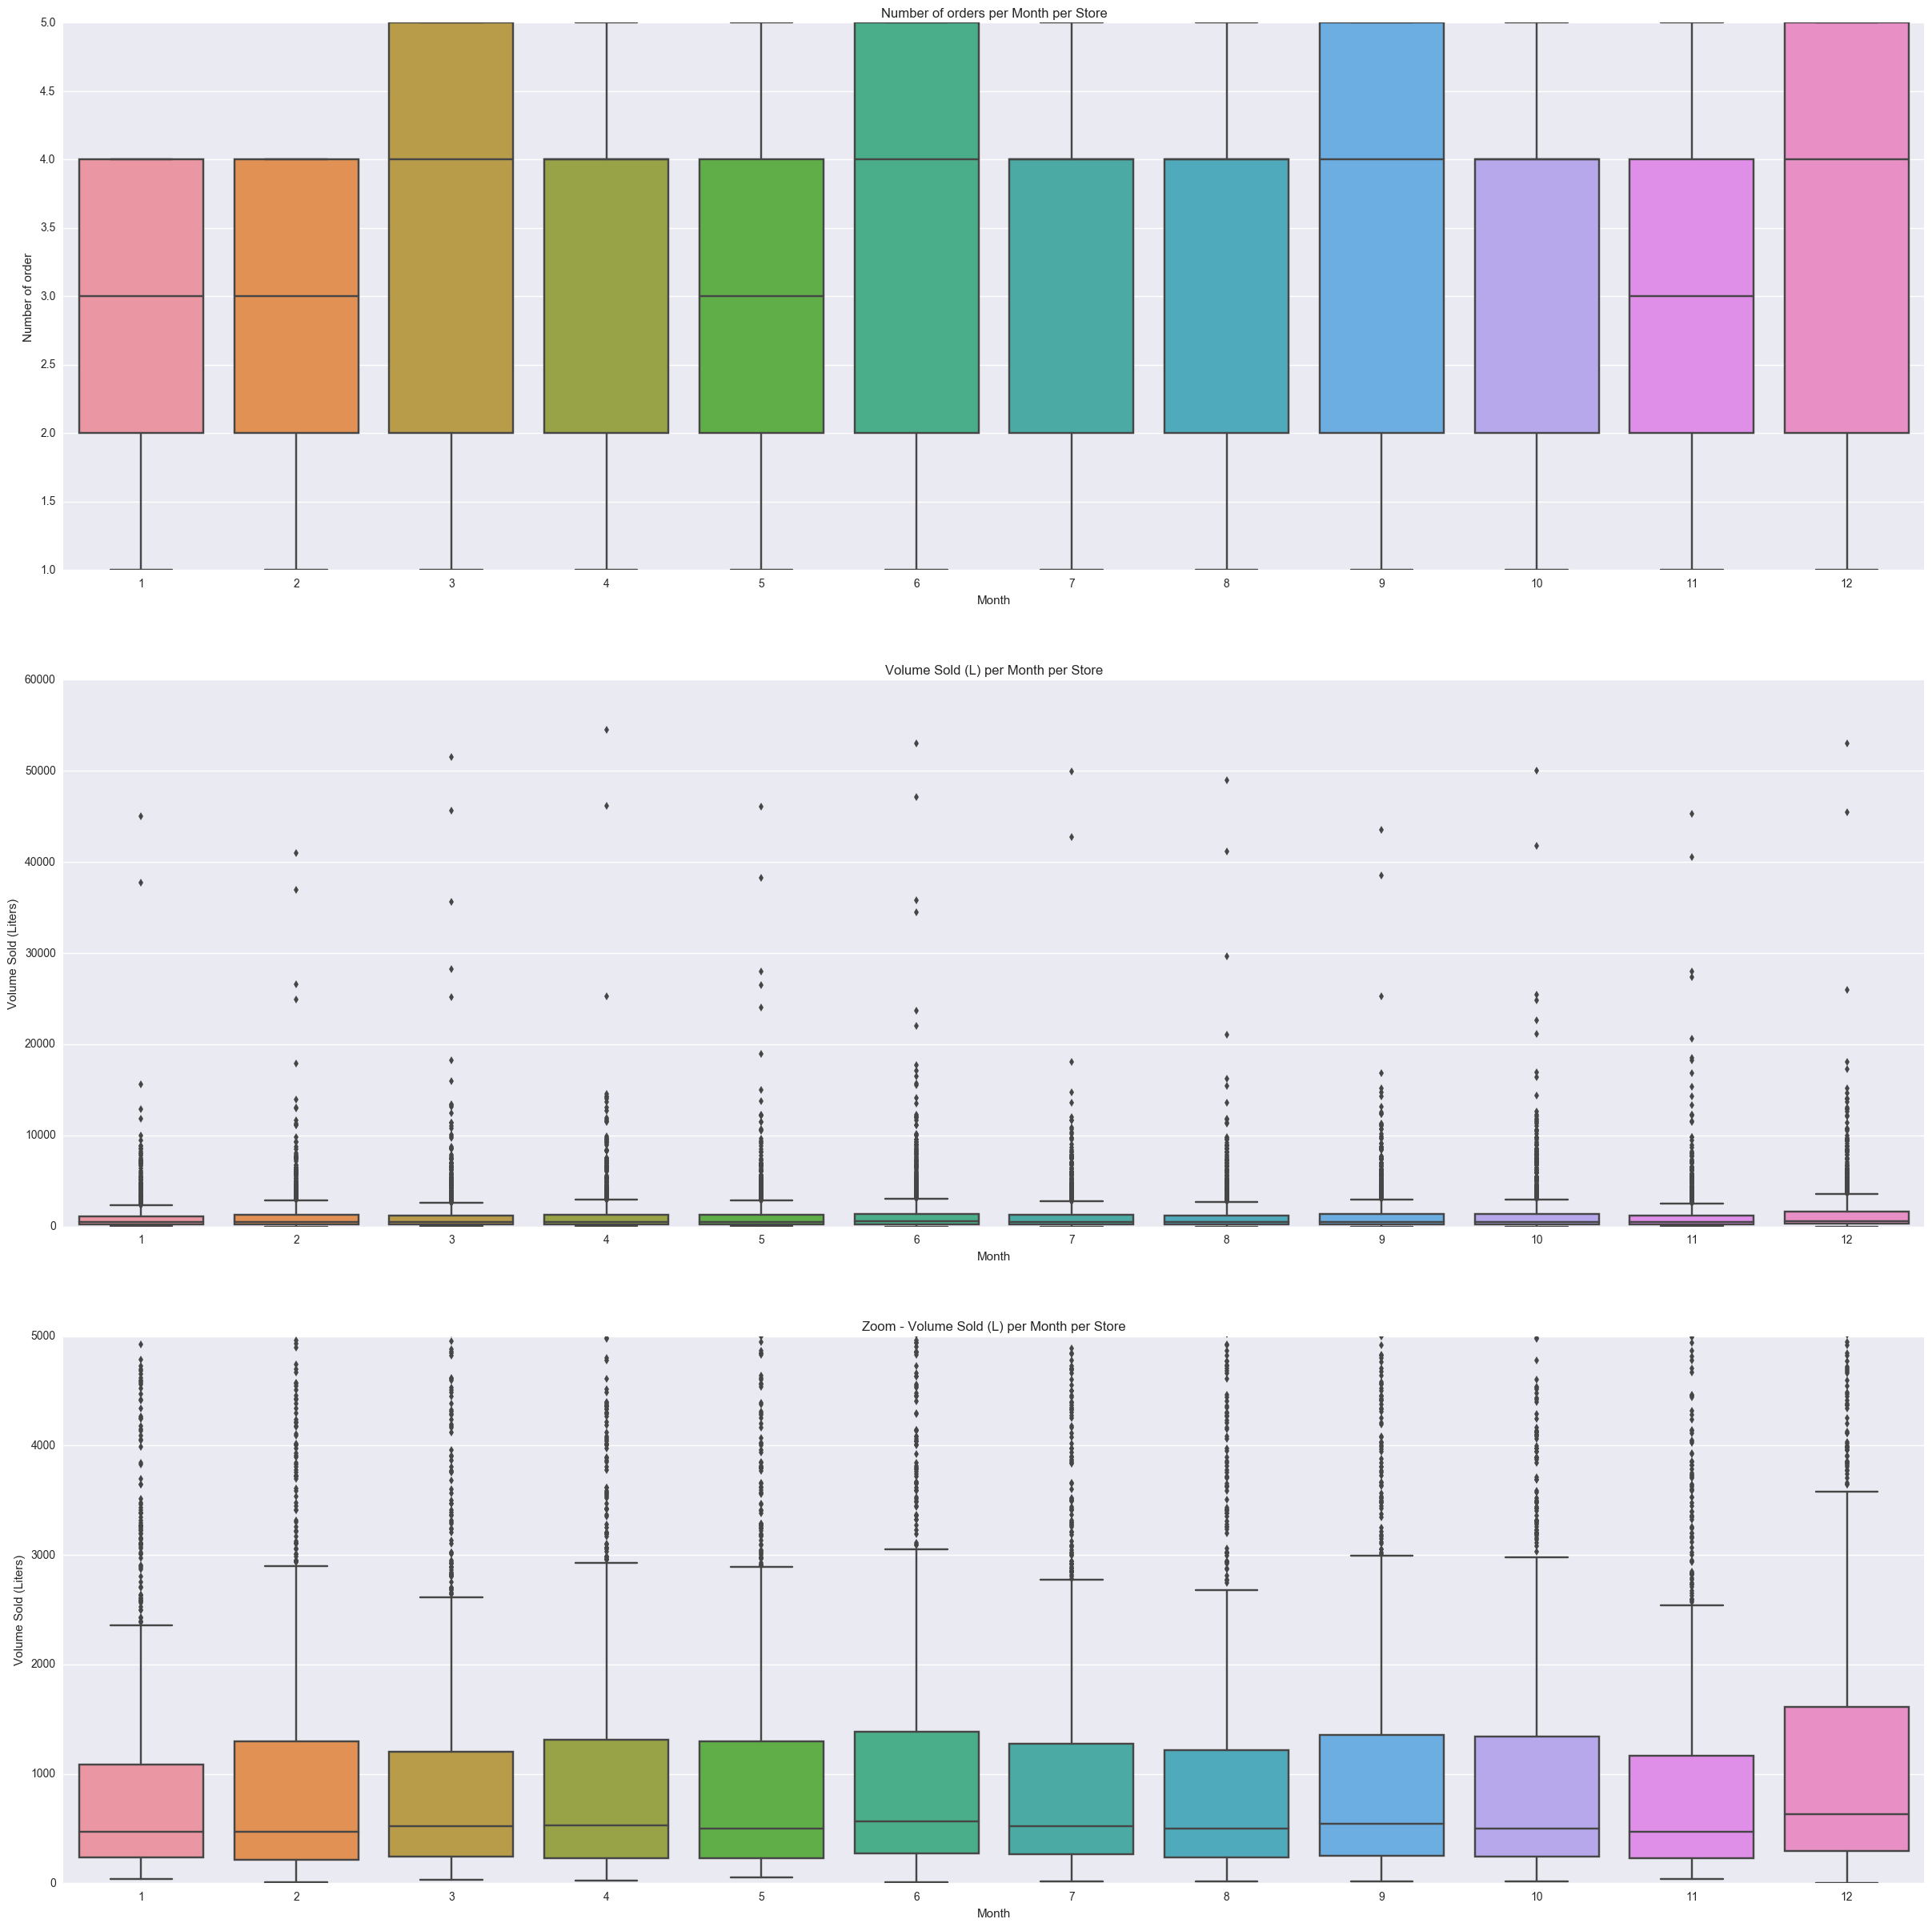

In [24]:
# let's plot 2 boxplots:
# one representing the number of orders per month per store
# second one representing the volume of orders per month per store

fig=plt.figure(figsize=(30,30))
ax1=fig.add_subplot(311)
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)

sns.boxplot(df_2015_store_order_consumption["Number of order"],groupby=df_2015_store_order_consumption.Month,ax=ax1)
ax
sns.boxplot(df_2015_store_order_consumption["Volume Sold (Liters)"],groupby=df_2015_store_order_consumption.Month,ax=ax2)

sns.boxplot(df_2015_store_order_consumption["Volume Sold (Liters)"],groupby=df_2015_store_order_consumption.Month,ax=ax3)
ax3.set_ylim((0,5000))

ax1.set_title("Number of orders per Month per Store")
ax2.set_title("Volume Sold (L) per Month per Store")
ax3.set_title("Zoom - Volume Sold (L) per Month per Store")
sns.plt.show()

the median for the number of orders per month is 4 weeks except for the 3 months with lower consumption.  
**This means a future prediction model at a month level has a risk of not taking into account the right weekly split per month although it will give us a good idea of the Sales volume for the month and get to know the expected revenue.**

**We can also point out the median order per month is about 5000 L per store but there are few store (outliers) with a huge amount order per month.**  
This outliers will hopefully be caught by a Ridge or Lasso regression model.

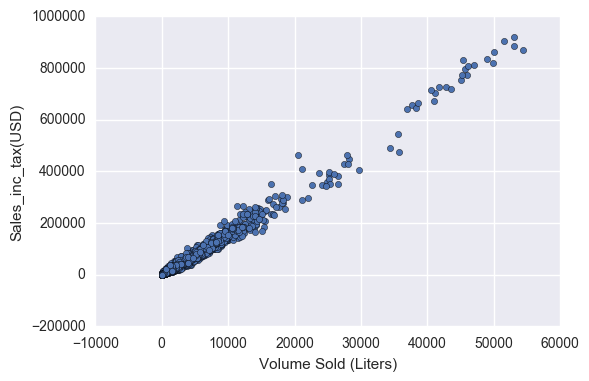

                         Month  Store Number  Sales_inc_tax(USD)  \
Month                 1.000000      0.031602            0.032833   
Store Number          0.031602      1.000000           -0.337432   
Sales_inc_tax(USD)    0.032833     -0.337432            1.000000   
Volume Sold (Liters)  0.026772     -0.374776            0.991023   
Number of order       0.079580     -0.382300            0.300893   

                      Volume Sold (Liters)  Number of order  
Month                             0.026772         0.079580  
Store Number                     -0.374776        -0.382300  
Sales_inc_tax(USD)                0.991023         0.300893  
Volume Sold (Liters)              1.000000         0.327947  
Number of order                   0.327947         1.000000  


In [25]:
# How link are Sales and Volume?

df_for_prediction=df_2015_store_order_consumption
df_for_prediction.plot.scatter("Volume Sold (Liters)","Sales_inc_tax(USD)")
plt.show()
print df_for_prediction.corr()

Sales and Volume are very well correlated with a pearson_r correlation of 0.99.
**We will make the assumption of 0% inflation as well as unique tax (50%) to predict Sales for 2016.**

___

In [26]:
from sklearn.cross_validation import train_test_split,cross_val_predict,cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import feature_selection, linear_model

# Before starting regression analysis, let’s have a look at where we are:

* The following assumption are made for the regression:
	* Sales Liquor type distribution in IOWA states will remain the same as 2015 as displayed in graph above with 3% allocated to other liquors;   
	* Liquor Type distribution for the state to be more or less equal at each store;  
	* Weekly sales order per store to be equally divided over a month.  

* We will use a k-fold cross-validation over all the months of 2015 to take into consideration seasonability and trends all along the year.

* It seems there are outliers store in a way that they ordered by far much more than the average.

Those assumptions can put our model at risk by making it more bias but, on a second hand, we will get a good overview of what will be the revenue for 2016.
Bear in my mind that the study of the impact of an increase/decrease in the price of a bottle has been performed. (Increase or decrease due to inflation/deflation over the bottle costs for IOWA States as example)



___

The idea is here to perform least squares, Ridge and Lasso regression with a k-fold cross-validation from an input ,the a combination of month and store number (X), to get an output, the sales per store (Y).  
To validate the model, I will compare the r2 coefficient for each case.  
Afterwards, I'll apply the best model to predict 2016 sales and already compare the first months available on that datasets.

In [54]:
#First we need to get the dummy variables for Store Number category.

df_for_prediction["Store Number"]=df_for_prediction["Store Number"].astype('category')
store_dummie=pd.get_dummies(df_for_prediction["Store Number"])
df_for_prediction=pd.concat([df_for_prediction,store_dummie],axis=1)

In [61]:
df_for_prediction=df_for_prediction.dropna()
df_for_prediction.reset_index(drop=True,inplace=True)

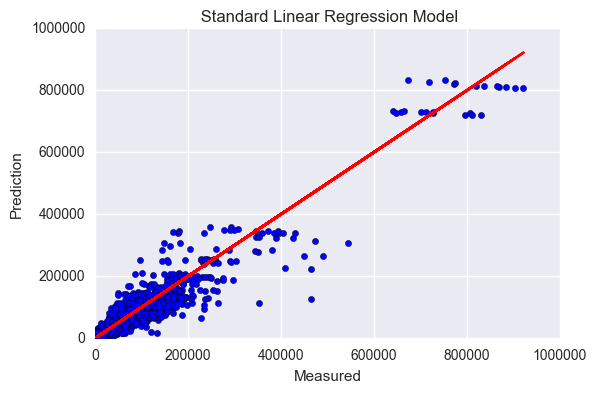

r^2 score: [ -1.05098957e+18   9.32686907e-01   9.35251949e-01   9.73064007e-01
   8.97209077e-01   9.38494301e-01   9.43180629e-01   9.20682442e-01
   9.36488801e-01   9.21336996e-01]
r^2 score global: -9.77554894134e+16
mse: 2.00966871463e+26


In [79]:
X=pd.concat([df_for_prediction.iloc[:,0],df_for_prediction.iloc[:,5:]],axis=1)
y=df_for_prediction["Sales_inc_tax(USD)"]

# Linear regression
lr=linear_model.LinearRegression(fit_intercept=True)
prediction=cross_val_predict(lr, X, y, cv=10)

plt.scatter(y,prediction,c='b')
plt.plot(y,y,c="r")
plt.xlabel("Measured")
plt.ylabel("Prediction")
plt.title(" Standard Linear Regression Model")
plt.ylim((0,1000000))
plt.xlim((0,1000000))
plt.show()
print "r^2 score:",cross_val_score(lr, X, y, cv=10)
print "r^2 score global:",r2_score(y,prediction)
print "mse:",mean_squared_error(y,prediction)

r2 is not so bad exept for the first test where the model create some negative value. 
However, the mse is far from our target 0!

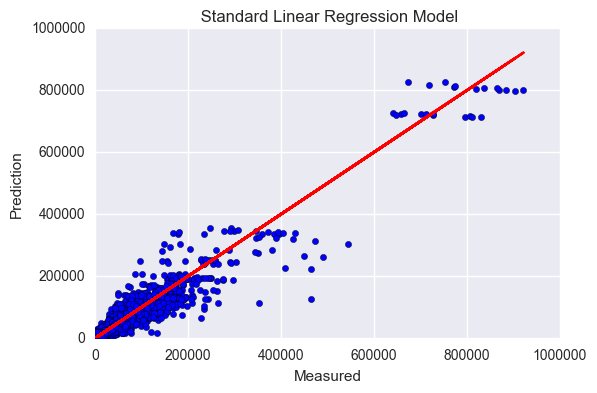

r^2 score: [ 0.88639972  0.93216816  0.93536714  0.97369605  0.89517389  0.94033861
  0.94430966  0.91985482  0.9358908   0.91918163]
r^2 score global: 0.927123874899
mse: 149819585.108


In [80]:

# Ridge regression
lr=linear_model.RidgeCV(fit_intercept=True)
prediction=cross_val_predict(lr, X, y, cv=10)

plt.scatter(y,prediction,c='b')
plt.plot(y,y,c="r")
plt.xlabel("Measured")
plt.ylabel("Prediction")
plt.title(" Standard Linear Regression Model")
plt.ylim((0,1000000))
plt.xlim((0,1000000))
plt.show()
print "r^2 score:",cross_val_score(lr, X, y, cv=10)
print "r^2 score global:",r2_score(y,prediction)
print "mse:",mean_squared_error(y,prediction)

It is getting better but our mse is still high even if we have to take into consideration that we are playing with big number!

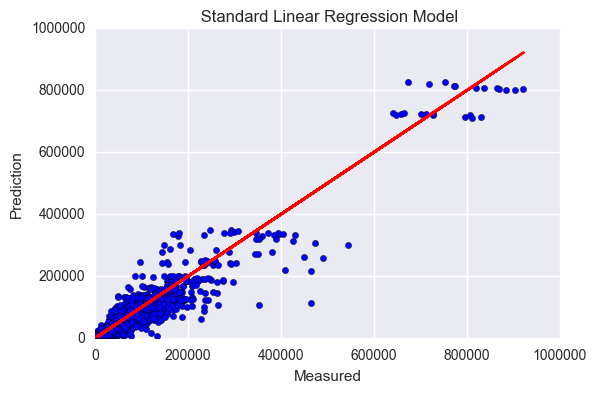

r^2 score: [ 0.89493268  0.92303393  0.92837836  0.96541118  0.87370516  0.93836368
  0.92948416  0.89698701  0.91950011  0.90112697]
r^2 score global: 0.915586131975
mse: 173539011.128


In [82]:
# Lasso regression
# With Lasso we can force our coefficient to be positive!
lr=linear_model.LassoCV(fit_intercept=True,positive=True)
prediction=cross_val_predict(lr, X, y, cv=10)

plt.scatter(y,prediction,c='b')
plt.plot(y,y,c="r")
plt.xlabel("Measured")
plt.ylabel("Prediction")
plt.title(" Standard Linear Regression Model")
plt.ylim((0,1000000))
plt.xlim((0,1000000))
plt.show()
print "r^2 score:",cross_val_score(lr, X, y, cv=10)
print "r^2 score global:",r2_score(y,prediction)
print "mse:",mean_squared_error(y,prediction)

This is good result but inferior to the Ridge regression, we will then choose the Ridge regression model.

___

# Predicting 2016

The idea is now to predict 2016 and compare our prediction with the first 3 months Jan, Fen and March 

In [27]:
# Let's first build df_2016

pivot_table_2016=pd.pivot_table(df,index=["year","month","Store Number"],values=["weeknum","Volume Sold (Liters)","Sales_inc_tax(USD)"],\
                            aggfunc= {"weeknum":lambda x: len(x.unique()),"Volume Sold (Liters)":np.sum,"Sales_inc_tax(USD)":np.sum})

# creation of a dataframe 
vol_Week_order=pd.DataFrame(data=pivot_table_2016.values,columns=["Sales_inc_tax(USD)","Volume Sold (Liters)","Number of order"])

# creation of a dataframe with the index 
list_of_tuples_month_store = pivot_table_2016.index.tolist()
list_of_lists = [list(elem) for elem in list_of_tuples_month_store]
list_of_lists[:10]
month_store=pd.DataFrame(data=list_of_lists,columns=["year","Month","Store Number"])

# concatenate

df_2016_for_prediction= pd.concat([month_store,vol_Week_order],axis=1)

# get dummies
df_2016_for_prediction["Store Number"]=df_2016_for_prediction["Store Number"].astype('category')
store_dummie=pd.get_dummies(df_2016_for_prediction["Store Number"])
df_2016_for_prediction=pd.concat([df_2016_for_prediction,store_dummie],axis=1)
df_2016_for_prediction.reset_index(drop=True,inplace=True)
df_2016_for_prediction.head()

,year,Month,Store Number,Sales_inc_tax(USD),Volume Sold (Liters),Number of order,2106,2113,2130,2152,2178,2190,2191,2200,2205,2228,2233,2238,2248,2285,2290,2327,2353,2367,2413,2445,2448,2459,2460,2465,2475,2478,2487,2498,2500,2501,2502,2505,2506,2507,2508,2509,2512,2513,2514,2515,2517,2518,2521,2522,2523,2524,2527,2528,2529,2532,2535,2536,2538,2539,2543,2544,2545,2548,2549,2550,2551,2552,2553,2554,2555,2556,2558,2559,2560,2561,2562,2564,2565,2566,2567,2568,2569,2571,2572,2573,2575,2576,2578,2579,2582,2584,2585,2587,2588,2590,2591,2592,2593,2594,...,5112,5113,5114,5115,5116,5117,5118,5119,5120,5121,5123,5124,5125,5126,5127,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5139,5140,5141,5142,5144,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154,5155,5156,5157,5159,5160,5161,5162,5163,5164,5165,5166,5167,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5185,5186,5187,5188,5189,5190,5191,5192,5193,5195,5196,5198,5199,5201,5202,5203,5204,5205,5206,5207,5211,5212,5213,5215,9001,9002,9010,9013,9018,9022,9023
0,2015,1,2106,109795.48,7116.85,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,1,2113,7685.86,566.74,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,1,2130,71307.51,4338.05,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,1,2152,5746.27,484.86,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [28]:
# Let's fit our Ridge model to 2015 then use it to predict y_2016
year_2015=df_2016_for_prediction.loc[df_2016_for_prediction["year"]==2015,:]
year_2015.reset_index(drop=True,inplace=True)

X_2015=pd.concat([year_2015.iloc[:,0],year_2015.iloc[:,5:]],axis=1)
y_2015=year_2015["Sales_inc_tax(USD)"]

year_2016=df_2016_for_prediction.loc[df_2016_for_prediction["year"]==2016,:]
year_2016.reset_index(drop=True,inplace=True)

X_2016=pd.concat([year_2016.iloc[:,0],year_2016.iloc[:,5:]],axis=1)
y_2016=year_2016["Sales_inc_tax(USD)"]


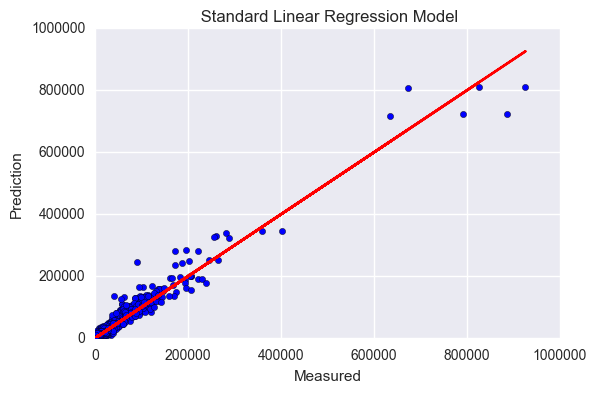

r^2 score global: 0.949929764048
mse: 90193208.8532
sse 90193208.8532
var 1891177519.04
bias -1800984310.19


In [29]:
# Ridge regression
lr=linear_model.RidgeCV(fit_intercept=True)
model=lr.fit(X_2015,y_2015)
prediction=model.predict(X_2016)

plt.scatter(y_2016,prediction,c='b')
plt.plot(y_2016,y_2016,c="r")
plt.xlabel("Measured")
plt.ylabel("Prediction")
plt.title(" Standard Linear Regression Model")
plt.ylim((0,1000000))
plt.xlim((0,1000000))
plt.show()

print "r^2 score global:",r2_score(y_2016,prediction)
print "mse:",mean_squared_error(y_2016,prediction)
print "sse",np.mean((y_2016-prediction)**2)
print "var",np.var(prediction)
print "bias",np.mean((y_2016-prediction)**2)-np.var(prediction) - 0.01

The r^2 score, close to 1 make us think that our model is fitting the reality but other metrics show the contraty.
This would mean that at an aggregated level our overal sales for the month is almost match but not at a store level.
Let's plot the prediction and the measured value from Jan to March

In [30]:
#Adding the prediction to our dataframe
year_2016["prediction"]=prediction

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [31]:
pivot_table21=pd.pivot_table(year_2016,index=["Month"],values=["Sales_inc_tax(USD)"],\
                            aggfunc= [np.sum])
pivot_table21.rename(columns={'sum':'Sales per month',"<lambda>":'%'}, inplace=True)
pivot_table31=pivot_table21.cumsum()
pivot_table31.rename(columns={'Sales per month':'Cumulative Sales',"<lambda>":'%'}, inplace=True)

pivot_table22=pd.pivot_table(year_2016,index=["Month"],values=["prediction"],\
                            aggfunc= [np.sum])
pivot_table22.rename(columns={'sum':'Sales per month',"<lambda>":'%'}, inplace=True)
pivot_table32=pivot_table22.cumsum()
pivot_table32.rename(columns={'Sales per month':'Cumulative Sales',"<lambda>":'%'}, inplace=True)



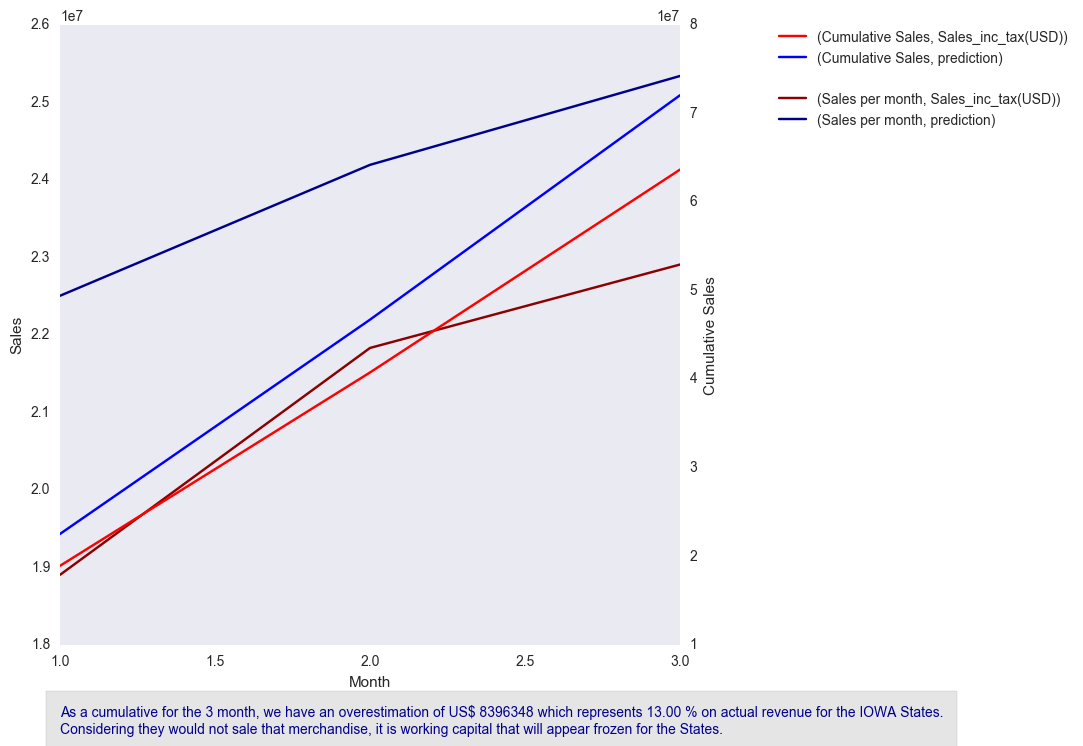

In [32]:
total_sales_prediction=int(np.sum(pivot_table22))
total_sales_2016=int(np.sum(pivot_table21))

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax2=ax.twinx()
pivot_table21.plot(ax=ax,grid=False,c='Darkred')
pivot_table22.plot(ax=ax,grid=False,c='Darkblue')

pivot_table31.plot(ax=ax2,c="r",grid=False)
pivot_table32.plot(ax=ax2,c="b",grid=False)
ax.set_ylabel("Sales")
ax2.set_ylabel("Cumulative Sales")

plt.text(1, 0, 'As a cumulative for the 3 month, we have an overestimation of US$ %d which represents %.2f %% on actual revenue for the IOWA States.\nConsidering they would not sale that merchandise,\
 it is working capital that will appear frozen for the States.'\
         %(total_sales_prediction-total_sales_2016,100*(total_sales_prediction-total_sales_2016)/total_sales_2016), \
         color='Darkblue',
        bbox={'facecolor':'grey', 'alpha':0.2, 'pad':10})

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.legend(bbox_to_anchor=(1.15, 0.9), loc=2, borderaxespad=0.)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
ax2.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)

plt.show()

_**Results:**_

We could say a window of +/-10 % would be a good result. In that case US$ 9 million of working capital frozen might not be taken well from IOWA citizens.

Before looking at the effect of tax rate change, our model need to be optimized.
This might be possible release one constraint made in our assumption. (i.e variability of sales during a month,\
look at sales tendency per category,etc)
